In [1]:
#Python modules for numerics and scientific computing
import numpy as np
import pandas as pd
import scipy as sp
import math

#scikit-learn
import sklearn.preprocessing as skpp
import sklearn.decomposition as skdecomp

#Matplotlib
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import mab_utils
import plot_utils as plu
#import tqdm

import interlab as inl
import pickle

In [2]:
jeffries = r'Symmetric Kullback-Liebler'

with open('mAb_interlab_project.sav','rb') as f:
    mab_project = pickle.load(f)

with open('mab_analysis_accessories.sav','rb') as f:
    (windowed_shape,jeffries,full_indices,split_point,
     ssi_contours,interp_map) = pickle.load(f)
    
metadata_table = pd.read_hdf('metadata_table_raw.h5',key='NMR_2D_raw',mode='r')

In [3]:
mab_project.fit_zscores()

In [4]:
mab_project.find_outliers(recursive=True,
                          support_fraction=0.85,
                          final_screen=True
                         )

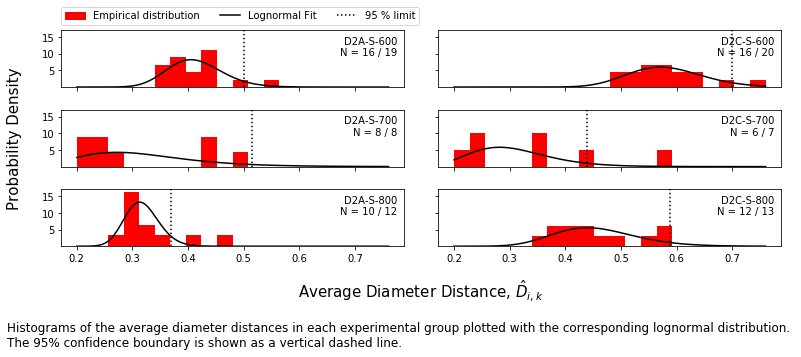

In [5]:
plot_range = ['D2A-S-600',
              'D2A-S-700',
              'D2A-S-800',
              'D2C-S-600',
              'D2C-S-700',
              'D2C-S-800',
             ]

f = mab_project.plot_histograms(jeffries,plot_range=plot_range,#['D2A-S-600','D2C-S-600'],
                                numcols=2)


empirical_red_patch = mpatches.Patch(color='red', label='Empirical distribution')
lognormal_line = mlines.Line2D([],[],color='k',label='Lognormal Fit')
confidence_limit = mlines.Line2D([],[],color='k',ls=':',label='95 % limit')
l = f.axes[0].legend(handles=[empirical_red_patch,lognormal_line,confidence_limit],
                     ncol=3,loc=(0.0,1.1))

caption_text = ('Histograms of the average diameter distances in each experimental group ' +
                'plotted with the corresponding lognormal distribution. \nThe 95% ' +
                'confidence boundary is shown as a vertical dashed line. ' 
               )

width,height = f.get_size_inches()

t = f.text(0,-0.25/height,caption_text,size=12,va='top')

In [6]:
mab_utils.save_outlier_data(metadata_table,mab_project,full_indices,
                                        split_point,metric=jeffries)
metadata_table.head(5)

,INDEX,DIR_NAME,CODE,TITLE,ExpType,ExpCode,File,ExptScore,Zscore,Outlier
0,1,8822,8822-010,D2C-S-U-900-8822-010-37C,800,D2C-S,./release3/new_ext/001-D2C-S-U-900-8822-010-37...,0,0.851621,False
1,2,7425,7425-010,D2A-S-U-900-7425-010-37C,800,D2A-S,./release3/new_ext/002-D2A-S-U-900-7425-010-37...,0,0.810390,False
2,3,7425,7425-012,D2C-S-U-900-7425-012-37C,800,D2C-S,./release3/new_ext/003-D2C-S-U-900-7425-012-37...,0,0.529562,False
3,4,7425,7425-015,D3A-F-U-900-7425-015-37C,800,D3A-F,./release3/new_ext/004-D3A-F-U-900-7425-015-37...,0,0.426977,False
4,5,8495,8495-010,D2A-S-U-900-8495-010-37C,800,D2A-S,./release3/new_ext/005-D2A-S-U-900-8495-010-37...,0,11.433257,False


In [7]:
plot_dict = dict(xlabel='$^1$H shift (ppm)',
                 ylabel='$^{13}$C shift (ppm)',
                 plot_corners = [1.9,-0.9,30.5,9],
                 shape=windowed_shape,
                 window=False,
                 sharex=True,sharey=True,
                 plotsize=(3,2),gridspec_kw=dict(hspace=0.05,wspace=0.05))

contour_colors_mappable = matplotlib.cm.ScalarMappable(
    cmap=mab_utils.seismic_with_alpha.reversed())

contour_colormap = contour_colors_mappable.get_cmap()
contours_rescale = np.interp(ssi_contours,*interp_map)

contour_colors = contour_colormap(contours_rescale)

/home/local/NIST/dsheen/.conda/envs/default_outside/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)


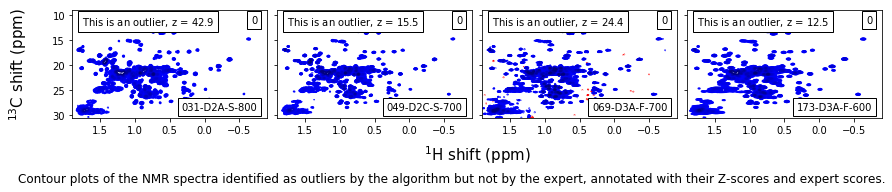

In [8]:
match_code = np.array([code.startswith('D') for code in metadata_table.ExpCode.values])
match_expert =  np.array([score==0 for score in metadata_table.ExptScore.values])
match_algori = np.array(metadata_table.Outlier)
match_outlier = np.logical_and(match_expert,match_algori)
#match_outlier =  np.logical_or(np.array(metadata_table.Outlier),np.array(metadata_table.LabOutlier))
match = np.logical_and(match_outlier,match_code)
bbox = dict(facecolor='w')

exps = metadata_table.iloc[match]
fig,axes = mab_utils.plot_the_nmr(exps,ncols=4,
                                  levels=ssi_contours,
                                  color=contour_colors,
                                  **plot_dict)
ax = axes.flatten()[0]
ax.invert_xaxis()
ax.invert_yaxis()
for score,ax in zip(metadata_table.ExptScore.values[match],axes.flatten()):
    ax.text(0.95,0.95,str(score),ha='right',va='top',transform=ax.transAxes,bbox=bbox)

caption_text = ('Contour plots of the NMR spectra identified as outliers by the algorithm ' +
                'but not by the expert, annotated with their Z-scores and expert scores.'
               )
width,height = fig.get_size_inches()

t = fig.text(0,-0.25/height,caption_text,size=12,va='top')

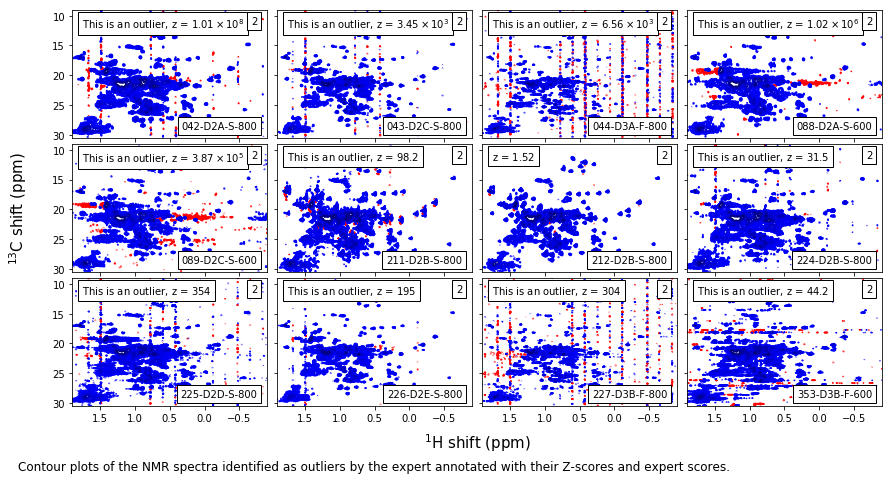

In [9]:
match_code = np.array([code.startswith('D') for code in metadata_table.ExpCode.values])
match_outlier =  np.array([score>1 for score in metadata_table.ExptScore.values])
#match_outlier =  np.logical_or(np.array(metadata_table.Outlier),np.array(metadata_table.LabOutlier))
match = np.logical_and(match_outlier,match_code)
bbox = dict(facecolor='w')

exps = metadata_table.iloc[match]
fig,axes = mab_utils.plot_the_nmr(exps,ncols=4,
                                  levels=ssi_contours,
                                  color=contour_colors,
                                  **plot_dict)
ax = axes.flatten()[0]
ax.invert_xaxis()
ax.invert_yaxis()
for score,ax in zip(metadata_table.ExptScore.values[match],axes.flatten()):
    ax.text(0.95,0.95,str(score),ha='right',va='top',transform=ax.transAxes,bbox=bbox)

caption_text = ('Contour plots of the NMR spectra identified as outliers by the expert ' +
                'annotated with their Z-scores and expert scores.'
               )
width,height = fig.get_size_inches()

t = fig.text(0,-0.25/height,caption_text,size=12,va='top')

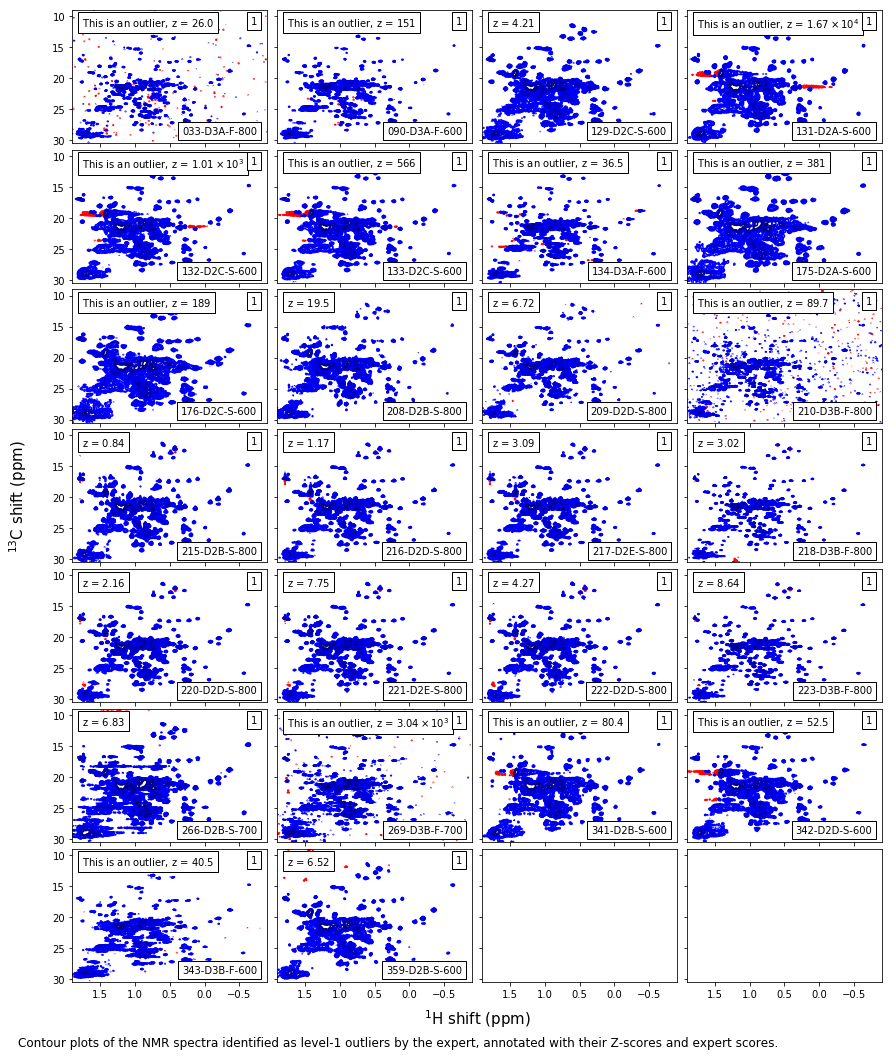

In [10]:
match_code = np.array([code.startswith('D') for code in metadata_table.ExpCode.values])
match_outlier =  np.array([score==1 for score in metadata_table.ExptScore.values])
#match_outlier =  np.logical_or(np.array(metadata_table.Outlier),np.array(metadata_table.LabOutlier))
match = np.logical_and(match_outlier,match_code)
bbox = dict(facecolor='w')

exps = metadata_table.iloc[match]
fig,axes = mab_utils.plot_the_nmr(exps,ncols=4,
                                  levels=ssi_contours,
                                  color=contour_colors,
                                  **plot_dict)
ax = axes.flatten()[0]
ax.invert_xaxis()
ax.invert_yaxis()
for score,ax in zip(metadata_table.ExptScore.values[match],axes.flatten()):
    ax.text(0.95,0.95,str(score),ha='right',va='top',transform=ax.transAxes,bbox=bbox)

caption_text = ('Contour plots of the NMR spectra identified as level-1 outliers by ' +
                'the expert, annotated with their Z-scores and expert scores.'
               )

width,height = fig.get_size_inches()

t = fig.text(0,-0.25/height,caption_text,size=12,va='top')

In [11]:
metadata_table.to_csv('metadata_table_recursive.csv',sep='\t')

In [12]:
keys_no_e = []
for key in ['600','700','800']:
    keys_no_e += [k for k in mab_project.Labels.keys() 
                  if k.startswith('D') and k.endswith(key)]

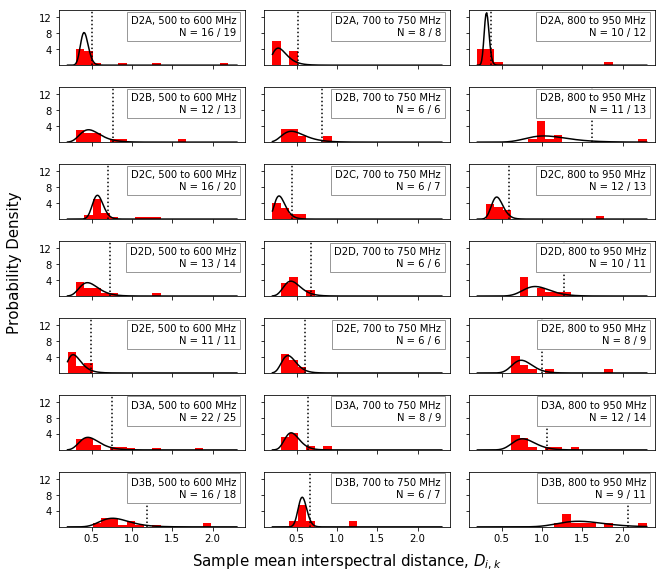

In [13]:
bbox_props = dict(edgecolor='0.6',facecolor='w')
f = mab_project.plot_histograms(jeffries,numcols=3,plot_range=keys_no_e)
size = f.get_size_inches()
vert_size = size[1]#*1.75
horz_size = size[0]/1.75
f.set_size_inches((horz_size,vert_size,))
for a in f.axes:
    t = a.texts[0]
    t_str = t.get_text()
    type_string = '-S-'
    if '-F-' in t_str:type_string = '-F-'
    if '600' in t_str:t_str = t_str.replace(type_string+'600',', 500 to 600 MHz')
    if '700' in t_str:t_str = t_str.replace(type_string+'700',', 700 to 750 MHz')
    if '800' in t_str:t_str = t_str.replace(type_string+'800',', 800 to 950 MHz')
    t.set_text(t_str)
    t.set_bbox(bbox_props)
    t.set_position((0.95,0.9))
f.texts[1].set_text('Sample mean interspectral distance, $D_{i,k}$')
f.subplots_adjust(left=0.08,bottom=0.08,wspace=0.0)


In [14]:
means = []
threshes = []
names = []
for x in mab_project:
    if x.name in keys_no_e:
        pop = x[jeffries].population
        params = pop.params
        dist = pop.distribution
        mean = dist.mean(*params)
        thresh = dist.ppf(0.9495,*params)
        
        name = x.name
        
        
        
        type_string = '-S-'
        if '-F-' in name:type_string = '-F-'
        if '600' in name:name = name.replace(type_string+'600',', low')
        if '700' in name:name = name.replace(type_string+'700',', med')
        if '800' in name:name = name.replace(type_string+'800',', high')
        
        print('{}: {:5.3f} {:5.3f}'.format(name,mean,thresh))

        means += [mean]
        threshes += [thresh]
        names += [name]

        #print(,params)

D2A, low: 0.414 0.500
D2A, med: 0.319 0.515
D2A, high: 0.317 0.370
D2B, low: 0.514 0.770
D2B, med: 0.507 0.814
D2B, high: 1.121 1.622
D2C, low: 0.583 0.700
D2C, med: 0.307 0.440
D2C, high: 0.457 0.588
D2D, low: 0.494 0.729
D2D, med: 0.468 0.676
D2D, high: 0.962 1.270
D2E, low: 0.311 0.491
D2E, med: 0.424 0.599
D2E, high: 0.775 1.003
D3A, low: 0.504 0.756
D3A, med: 0.462 0.638
D3A, high: 0.800 1.064
D3B, low: 0.825 1.183
D3B, med: 0.577 0.669
D3B, high: 1.537 2.065


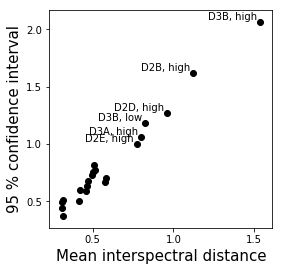

In [15]:
fig,ax = plt.subplots(figsize=(4,4))

ax.scatter(means,threshes,color='k')
ax.set_xlabel('Mean interspectral distance',size=15)
ax.set_ylabel('95 % confidence interval',size=15)
ax.set_yticks([0.5,1,1.5,2])
ax.set_xticks([0.5,1,1.5])
for n,m,t in zip(names,means,threshes):   
    if t > 1:    ax.text(m-0.02,t,n,ha='right',va='bottom')
    

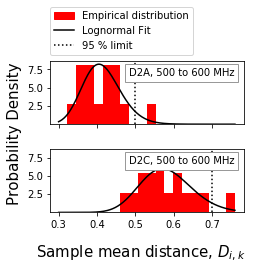

In [33]:
keys_for_slide= [
    'D2A-S-600',
    'D2C-S-600',
]

bbox_props = dict(edgecolor='0.6',facecolor='w')
f = mab_project.plot_histograms(jeffries,numcols=1,plot_range=keys_for_slide)
size = f.get_size_inches()
vert_size = size[1]#*1.75
horz_size = size[0]/1.75
f.set_size_inches((horz_size,vert_size,))
for a in f.axes:
    t = a.texts[0]
    t_str = t.get_text().split('\n')[0]
    type_string = '-S-'
    if '-F-' in t_str:type_string = '-F-'
    if '600' in t_str:t_str = t_str.replace(type_string+'600',', 500 to 600 MHz')
    if '700' in t_str:t_str = t_str.replace(type_string+'700',', 700 to 750 MHz')
    if '800' in t_str:t_str = t_str.replace(type_string+'800',', 800 to 950 MHz')
    t.set_text(t_str)
    t.set_bbox(bbox_props)
    t.set_position((0.95,0.9))
empirical_red_patch = mpatches.Patch(color='red', label='Empirical distribution')
lognormal_line = mlines.Line2D([],[],color='k',label='Lognormal Fit')
confidence_limit = mlines.Line2D([],[],color='k',ls=':',label='95 % limit')
l = f.axes[0].legend(handles=[empirical_red_patch,lognormal_line,confidence_limit],
                     ncol=1,loc=(0.0,1.1))

f.texts[1].set_text('Sample mean distance, $D_{i,k}$')
f.subplots_adjust(left=0.18,bottom=0.25,hspace=0.0,wspace=0.0)
